# 1. Prepare

## 1.1. Settings

In [1]:
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import concatenate, Dense, Dropout, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import threading
import time

%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
input_size = 299
dropout = 0.8
batch_size = 16
batch_size_val = 16

epochs_phase_1 = 10
epochs_phase_2 = 20
epochs_phase_3 = 20

cpu_threads = 8

output_directory = './output/inceptionV3_with_dimensions_20171108'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    os.makedirs(os.path.join(output_directory, 'checkpoints'))

## 1.2. Data and augmentaion

In [3]:
train_directory = './data2/train'
validation_directory = './data2/validation'
test_directory = './data2/test'

In [4]:
def measure_seed(image, normalize=True):
    # convert to 0-255 BGR image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.convertScaleAbs(image, alpha=(255.0))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (15, 15), 0)
    _, threshold = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)
    
    _, contours, _ = cv2.findContours(opening.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # choose contour with the largest area
    contours.sort(key=lambda c: cv2.contourArea(c))
    cnt = contours[-1]
    
    _, _, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    extent = float(area) / w * h
    solidity = float(area) / cv2.contourArea(cv2.convexHull(cnt))
    
    _, size, _ = cv2.minAreaRect(cnt)

    w_r = int(sorted(size)[0])
    h_r = int(sorted(size)[1])
    
    if normalize:
        # x_norm = (x - X_min)/(X_max - X_min)
        w_r = (w_r - 16)/171
        h_r = (h_r - 24)/266
        area = (area - 493)/44639
        perimeter = (perimeter - 86.97)/1186.53
        extent = (extent - 414.9)/41399.56
    
    return [w_r, h_r, area, perimeter, extent, solidity]

In [5]:
# https://stackoverflow.com/a/41645042/1779687
class batchGenerator:
    def __init__(self, directory, generator, batch_size=16, shuffle=False):
        gen = generator.flow_from_directory(
            directory,
            target_size=(input_size, input_size),
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=shuffle)
        self.generator = gen
        
        self.samples = gen.samples
        self.num_class = gen.num_class
        self.classes = gen.classes
        self.class_indices = gen.class_indices
        
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            X, y = self.generator.next()
            dimensions = [measure_seed(x) for x in X]
            return [np.array(X), np.array(dimensions)], y

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

validgen = ImageDataGenerator(rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

train_generator = batchGenerator(
    train_directory,
    datagen,
    batch_size=batch_size,
    shuffle=True)

validation_generator = batchGenerator(
    validation_directory,
    validgen,
    batch_size=batch_size_val,
    shuffle=True)

test_generator = batchGenerator(
    test_directory,
    testgen,
    batch_size=1,
    shuffle=False)

train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

num_classes = train_generator.num_class

Found 3695 images belonging to 7 classes.
Found 31383 images belonging to 7 classes.
Found 1846 images belonging to 7 classes.


## 1.3. Model

In [7]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size, input_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
inception_out = Dropout(dropout)(x)

aux_input = Input(shape=(6,), name='aux_input')
aux = Dense(256, activation='relu')(aux_input)

x = concatenate([inception_out, aux])
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[base_model.input, aux_input], outputs=predictions)

# 2. Train

## 2.1. Phase 1
Train only the top layers (which were randomly initialized).

In [8]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_1.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_1.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.05,
    patience=2,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_1'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_1,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/10
230/230 [==============================] - 387s - loss: 1.8321 - acc: 0.5367 - val_loss: 0.9296 - val_acc: 0.6927
Epoch 2/10
230/230 [==============================] - 377s - loss: 1.0300 - acc: 0.7100 - val_loss: 0.8694 - val_acc: 0.7419
Epoch 3/10
230/230 [==============================] - 376s - loss: 0.9544 - acc: 0.7175 - val_loss: 0.8222 - val_acc: 0.7488
Epoch 4/10
230/230 [==============================] - 377s - loss: 0.9262 - acc: 0.7266 - val_loss: 0.7797 - val_acc: 0.7535
Epoch 5/10
230/230 [==============================] - 379s - loss: 0.9154 - acc: 0.7287 - val_loss: 0.7772 - val_acc: 0.7464
Epoch 6/10
230/230 [==============================] - 377s - loss: 0.9287 - acc: 0.7364 - val_loss: 0.7496 - val_acc: 0.7579
Epoch 00005: early stopping


Load best epoch:

In [9]:
model.load_weights('{}/checkpoints/phase_1.h5'.format(output_directory))

## 2.2. Phase 2
At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [10]:
# train the top 2 inception blocks
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.adam(lr=1e-4),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_2.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_2.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=5,
    verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_2'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
230/230 [==============================] - 382s - loss: 0.8192 - acc: 0.7568 - val_loss: 1.9093 - val_acc: 0.7270
Epoch 2/20
230/230 [==============================] - 378s - loss: 0.7219 - acc: 0.7668 - val_loss: 0.6106 - val_acc: 0.7779
Epoch 3/20
230/230 [==============================] - 379s - loss: 0.6860 - acc: 0.7684 - val_loss: 0.6008 - val_acc: 0.7795
Epoch 4/20
230/230 [==============================] - 380s - loss: 0.6756 - acc: 0.7668 - val_loss: 0.5840 - val_acc: 0.7776
Epoch 5/20
230/230 [==============================] - 379s - loss: 0.6388 - acc: 0.7682 - val_loss: 0.5288 - val_acc: 0.7885
Epoch 6/20
230/230 [==============================] - 379s - loss: 0.6005 - acc: 0.7769 - val_loss: 0.4894 - val_acc: 0.7897
Epoch 7/20
230/230 [==============================] - 381s - loss: 0.5617 - acc: 0.7771 - val_loss: 0.4863 - val_acc: 0.7906
Epoch 8/20
230/230 [==============================] - 380s - loss: 0.5532 - acc: 0.7809 - val_loss: 0.4926 - val_acc: 0.7900


Load best epoch:

In [12]:
model.load_weights('{}/checkpoints/phase_2.h5'.format(output_directory))

## 2.3. Phase 3
Train all layers.

In [13]:
for layer in model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='{}/checkpoints/phase_3.h5'.format(output_directory),
    save_weights_only=True,
    save_best_only=True)

csv_logger = CSVLogger('{}/logs/phase_3.csv'.format(output_directory), separator=';')

early_stopper = EarlyStopping(
    monitor='val_acc',
    min_delta=0.005,
    patience=5,
    verbose=1)

lr_reduce = ReduceLROnPlateau(verbose=1)

tensorboard = TensorBoard(
    log_dir='{}/logs/phase_3'.format(output_directory),
    write_graph=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs_phase_3,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size_val,
    verbose=1,
    callbacks=[checkpointer, csv_logger, lr_reduce, early_stopper, tensorboard],
    workers=cpu_threads)

Epoch 1/20
230/230 [==============================] - 442s - loss: 0.3633 - acc: 0.8701 - val_loss: 0.3609 - val_acc: 0.8794
Epoch 2/20
230/230 [==============================] - 439s - loss: 0.3466 - acc: 0.8806 - val_loss: 0.3521 - val_acc: 0.8807
Epoch 3/20
230/230 [==============================] - 439s - loss: 0.3479 - acc: 0.8703 - val_loss: 0.3504 - val_acc: 0.8797
Epoch 4/20
230/230 [==============================] - 439s - loss: 0.3431 - acc: 0.8810 - val_loss: 0.3437 - val_acc: 0.8831
Epoch 5/20
230/230 [==============================] - 438s - loss: 0.3458 - acc: 0.8744 - val_loss: 0.3446 - val_acc: 0.8805
Epoch 6/20
230/230 [==============================] - 439s - loss: 0.3278 - acc: 0.8766 - val_loss: 0.3401 - val_acc: 0.8820
Epoch 7/20
230/230 [==============================] - 439s - loss: 0.3512 - acc: 0.8744 - val_loss: 0.3432 - val_acc: 0.8825
Epoch 00006: early stopping


Load best epoch:

In [14]:
model.load_weights('{}/checkpoints/phase_3.h5'.format(output_directory))

# 3. Evaluate

## 3.1. Evaluate

In [15]:
score = model.evaluate_generator(test_generator, test_samples)

print('Test accuracy: {:.2f}'.format(score[1]))

Test accuracy: 0.89


## 3.2. Propagation time

In [16]:
# initialize generator to fix imeges order
test_generator = batchGenerator(
    test_directory,
    testgen,
    batch_size=1,
    shuffle=False)

t0 = time.time()
prediction = model.predict_generator(test_generator, test_samples)
pred_time = time.time() - t0

print('Propagation time of {} images: {:.3f} ms ({:.3f} ms per image)'.format(test_samples, pred_time * 1000.0, pred_time / test_samples * 1000.0))

Found 1846 images belonging to 7 classes.
Propagation time of 1846 images: 47299.783 ms (25.623 ms per image)


## 3.3. Confusion matrix

In [17]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

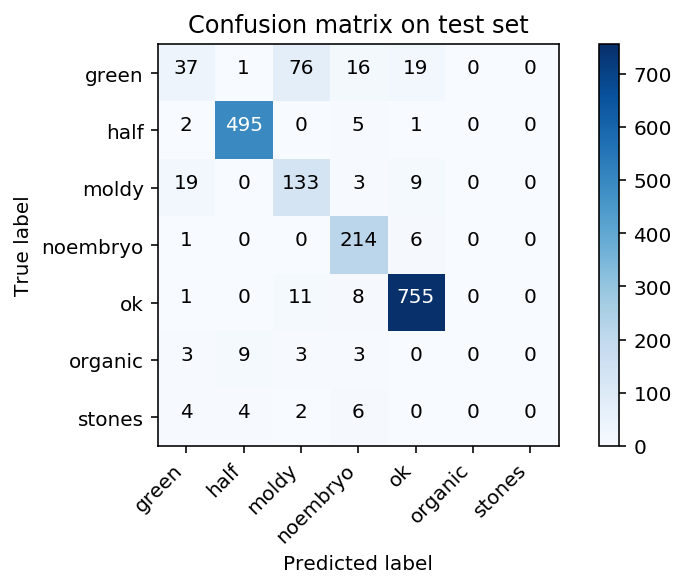

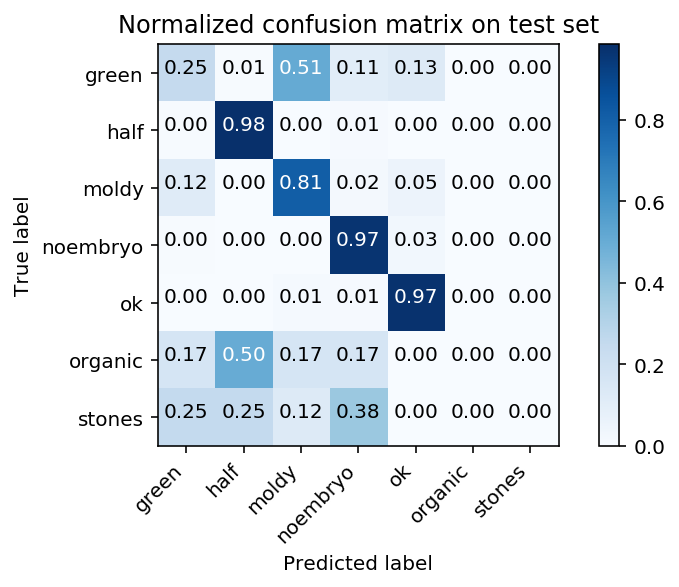

In [18]:
class_names = [key for (key, value) in sorted(test_generator.class_indices.items())]

test_pred = []
for i in prediction:
    test_pred.append(np.argmax(i))

test_cnf_matrix = confusion_matrix(test_generator.classes, test_pred)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names,
                      title='Confusion matrix on test set')
plt.figure()
plot_confusion_matrix(test_cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix on test set')
plt.show()